In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision.transforms as T
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
# try:
#     import timm
# except ImportError:
#     print("Please install timm: pip install timm")
#     timm = None
from transformers import ViTForImageClassification
from tqdm import tqdm

C:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
vit_model = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10')

In [4]:
import os
import sys
module_path = os.path.join(os.getcwd(), '..')
sys.path.append(module_path)

In [5]:
from lrp_engine import LRPEngine, checkpoint_hook

In [6]:
# Load a pretrained ViT model (trained on ImageNet)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def get_vit_model():
    vit_feature_extractor = ViTFeatureExtractor.from_pretrained('nateraw/vit-base-patch16-224-cifar10')
    vit_model = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10')

    # vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)
    vit_model.eval()
    
    for block in vit_model.blocks:
        block.attn.register_forward_hook(checkpoint_hook)
    return vit_model, vit_feature_extractor

# Load a couple of dog and cat images from ImageNet (torchvision)
def get_imagenet_samples(num_samples=2):
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    # Download ImageNet val subset (tiny-imagenet or use CIFAR10 for demo)
    # TODO: Mybe we should use a Hi Res dataset instead for the examples
    dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    # Class 3 = cat, Class 5 = dog
    imgs_list = []
    labels_list = []
    for image, label in dataset:
        if label in [3, 5]:
            imgs_list.append(image)
            labels_list.append(label)
        if len(imgs_list) >= num_samples:
            break
    return imgs_list, labels_list

#Run forward pass and get prediction
def predict(model, img_tensor):
    with torch.no_grad():
        output_tensor = model(img_tensor)
        pred_idx = output_tensor.argmax(dim=1).item()
    return output_tensor, pred_idx

# Run LRP_promises  to get patch attributions. Not sure I have initialize first
# but it should be ok because all images are of the same size
def get_patch_attributions(model, img_tensor, pred_class, lrp_engine):
    img_tensor.requires_grad_(True)
    output = model(img_tensor)

    # Extract hidden states if available
    hidden_states = None
    if hasattr(output, 'hidden_states'):
        hidden_states = output.hidden_states
    elif isinstance(output, tuple) and len(output) > 1:
        hidden_states = output[1]
    elif isinstance(output, torch.Tensor):
        hidden_states = output
    else:
        raise RuntimeError('Could not extract hidden states from model output.')
    if hidden_states is None and hasattr(output, 'logits'):
        hidden_states = output.logits
    # Call lrp_engine as in the DNABERT-2 notebook
    return lrp_engine.run(hidden_states)

# Visualize attributions
def visualize_attributions(img_tensor, patch_relevance, title=None, show_img=True):
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img_np = img_np.clip(0, 1)
    plt.figure(figsize=(4,4))
    if show_img:
        plt.imshow(img_np)
    # Use the first tensor in patch_relevance list? 
    # relevance_map = patch_relevance[-1].reshape(14,14)
    plt.imshow(patch_relevance, cmap='jet', alpha=0.5 if show_img else 1)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

# Plot image
def plot_img(img_tensor):
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img_np = img_np.clip(0, 1)
    plt.figure(figsize=(4,4))
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()

In [7]:
# vit_model = get_vit_model()
# print("We got the model :)")
# vit_model.to(device)

In [7]:
vit_model.to(device)
vit_model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [8]:
num_samples = 1000
imgs_list, labels_list = get_imagenet_samples(num_samples=num_samples)
print(f"Loaded {len(imgs_list)} images")

Loaded 1000 images


In [10]:
# # # Plot the original images
# plt.figure(figsize=(10, 5))
# for i, (img_tensor, label) in enumerate(zip(imgs_list, labels_list)):
#     plt.subplot(1, len(imgs_list), i+1)
#     img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
#     img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
#     img_np = img_np.clip(0, 1)
#     plt.imshow(img_np)
#     plt.title(f"True Label: {label}")
#     plt.axis('off')
# plt.tight_layout()
# plt.show()

In [9]:
def evaluateViT(model, engine, examples, labels, run_lrp=True):
    heatmaps = []
    preds = [0, 0]
    data = list(zip(imgs_list, labels_list))
    for i in tqdm(range(len(examples))):
        img_tensor = examples[i]
        true_label = labels[i]
        img_tensor = img_tensor.unsqueeze(0).to(device)
        # output_tensor, pred_idx = predict(vit_model, img_tensor)
        output = model(img_tensor)
        pred_idx = output.logits.argmax(dim=-1)
        if pred_idx == true_label:
            preds[0] += 1
        else:
            preds[1] += 1

        if run_lrp:
            if i == 0 and engine.param_node_inds is None:
                engine.params_to_interpret = [ img_tensor ]
            relevance_outputs= get_patch_attributions(model, img_tensor, pred_idx, engine)
            heatmaps.append((pred_idx, relevance_outputs[1][0]))

    return heatmaps, preds

In [10]:
lrp_engine = LRPEngine(use_gamma=True)

In [11]:
heatmaps, preds0 = evaluateViT(vit_model, lrp_engine, imgs_list, labels_list)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:06<00:00,  7.90it/s]


In [12]:
blur = T.GaussianBlur(kernel_size=51, sigma=20)
blurred_imgs = [ blur(img) for img in imgs_list ]

In [13]:
patch_size = 16
num_patches = 224 // patch_size
occlusion_step = 4
assert 224 % patch_size == 0, "224 must be divisible by patch_size"
max_patch_pool = torch.nn.MaxPool2d(kernel_size=patch_size, stride=patch_size)
min_patch_pool = lambda x: -torch.nn.MaxPool2d(kernel_size=patch_size, stride=patch_size)(x)
heatmap_pos_patches = [ max_patch_pool(hm.sum(dim=1)).squeeze(0) for _, hm in heatmaps ]
# heatmap_neg_patches = [ min_patch_pool(hm.sum(dim=1)).squeeze(0) for _, hm in heatmaps ]
patch_mask_morf = [ patches.flatten().topk(occlusion_step).indices.cpu() for patches in heatmap_pos_patches ]
patch_mask_lerf = [ patches.flatten().topk(occlusion_step, largest=False).indices.cpu() for patches in heatmap_pos_patches ]

In [24]:
morf_imgs_list, _ = get_imagenet_samples(num_samples=num_samples)
print(f"Loaded {len(imgs_list)} images")

Loaded 1000 images


In [25]:
import random
occlusion_iters = 40
occlusion_start_ind = 0

morf_preds = []

mean_pixels = [ img.mean(dim=[-1, -2]) for img in imgs_list ]
for i in range(occlusion_start_ind, occlusion_iters):
    # Do occlusion
    for j in range(len(morf_imgs_list)):
        patch_inds = patch_mask_morf[j]
        for patch in patch_inds[-occlusion_step:]:
            x = (patch // num_patches) * patch_size
            y = (patch % num_patches) * patch_size
            # samplex = random.randint(0,223)
            # sampley = random.randint(0,223)
            # morf_imgs_list[j][:,x:x+patch_size,y:y+patch_size] =  morf_imgs_list[j][:,samplex,sampley].unsqueeze(1).unsqueeze(1)
            morf_imgs_list[j][:,x:x+patch_size,y:y+patch_size] = blurred_imgs[j][:,x:x+patch_size,y:y+patch_size]

    _, preds = evaluateViT(vit_model, lrp_engine, morf_imgs_list, labels_list, run_lrp=False)
    morf_preds.append(preds)
    patch_mask_morf = [ patches.flatten().topk((i + 2) * occlusion_step).indices.cpu() for patches in heatmap_pos_patches ]
    print(preds)

        
        

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.24it/s]


[938, 62]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.06it/s]


[925, 75]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.65it/s]


[924, 76]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.29it/s]


[913, 87]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.15it/s]


[901, 99]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.35it/s]


[886, 114]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.06it/s]


[872, 128]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.50it/s]


[853, 147]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.02it/s]


[841, 159]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.09it/s]


[833, 167]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.08it/s]


[815, 185]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


[801, 199]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.21it/s]


[778, 222]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.59it/s]


[757, 243]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.68it/s]


[732, 268]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.40it/s]


[729, 271]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.44it/s]


[714, 286]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.18it/s]


[695, 305]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.26it/s]


[663, 337]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.72it/s]


[654, 346]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.09it/s]


[653, 347]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.91it/s]


[643, 357]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.57it/s]


[633, 367]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.61it/s]


[606, 394]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.72it/s]


[590, 410]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.00it/s]


[584, 416]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.65it/s]


[585, 415]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.76it/s]


[574, 426]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.59it/s]


[576, 424]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.79it/s]


[556, 444]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.51it/s]


[550, 450]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


[552, 448]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.39it/s]


[550, 450]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.84it/s]


[554, 446]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


[544, 456]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.04it/s]


[547, 453]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.66it/s]


[542, 458]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.72it/s]


[542, 458]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.57it/s]


[544, 456]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.58it/s]


[542, 458]


In [26]:
lerf_imgs_list, labels_list = get_imagenet_samples(num_samples=num_samples)
print(f"Loaded {len(imgs_list)} images")

Loaded 1000 images


In [28]:
lerf_preds = []

for i in range(occlusion_start_ind, occlusion_iters):
    # Do occlusion
    for j in range(len(lerf_imgs_list)):
        patch_inds = patch_mask_lerf[j]
        for patch in patch_inds[-occlusion_step:]:
            x = (patch // num_patches) * patch_size
            y = (patch % num_patches) * patch_size
            # samplex = random.randint(0,223)
            # sampley = random.randint(0,223)
            # lerf_imgs_list[j][:,x:x+patch_size,y:y+patch_size] =  lerf_imgs_list[j][:,samplex,sampley].unsqueeze(1).unsqueeze(1)
            lerf_imgs_list[j][:,x:x+patch_size,y:y+patch_size] = blurred_imgs[j][:,x:x+patch_size,y:y+patch_size]

    _, preds = evaluateViT(vit_model, lrp_engine, lerf_imgs_list, labels_list, run_lrp=False)
    lerf_preds.append(preds)
    patch_mask_lerf = [ patches.flatten().topk((i + 2) * occlusion_step, largest=False).indices.cpu() for patches in heatmap_pos_patches ]
    print(i, preds)

        
        

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.68it/s]


0 [933, 67]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.66it/s]


1 [930, 70]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.90it/s]


2 [929, 71]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.15it/s]


3 [927, 73]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.37it/s]


4 [921, 79]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.72it/s]


5 [913, 87]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.40it/s]


6 [914, 86]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.13it/s]


7 [915, 85]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.05it/s]


8 [918, 82]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.41it/s]


9 [911, 89]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.13it/s]


10 [902, 98]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.55it/s]


11 [897, 103]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.56it/s]


12 [893, 107]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.29it/s]


13 [890, 110]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.23it/s]


14 [878, 122]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.77it/s]


15 [874, 126]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.19it/s]


16 [868, 132]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.57it/s]


17 [856, 144]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.07it/s]


18 [850, 150]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.76it/s]


19 [840, 160]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.53it/s]


20 [833, 167]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


21 [826, 174]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.21it/s]


22 [811, 189]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.95it/s]


23 [798, 202]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.14it/s]


24 [781, 219]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.55it/s]


25 [768, 232]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.59it/s]


26 [738, 262]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.74it/s]


27 [737, 263]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.38it/s]


28 [730, 270]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.30it/s]


29 [712, 288]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.26it/s]


30 [698, 302]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.36it/s]


31 [678, 322]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.31it/s]


32 [656, 344]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.68it/s]


33 [626, 374]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.02it/s]


34 [608, 392]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.83it/s]


35 [589, 411]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.10it/s]


36 [566, 434]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.33it/s]


37 [551, 449]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.24it/s]


38 [537, 463]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.10it/s]


39 [531, 469]


In [29]:
x_axis = torch.arange(0, occlusion_iters + 1, 1) * 4
y_axis_morf = [ p[0] / (p[0] + p[1]) for p in [preds0] + morf_preds ]
y_axis_lerf = [ p[0] / (p[0] + p[1]) for p in [preds0] + lerf_preds ]

In [38]:
x_axis = x_axis[:39]
y_axis_morf = y_axis_morf[:39]
y_axis_lerf = y_axis_lerf[:39]

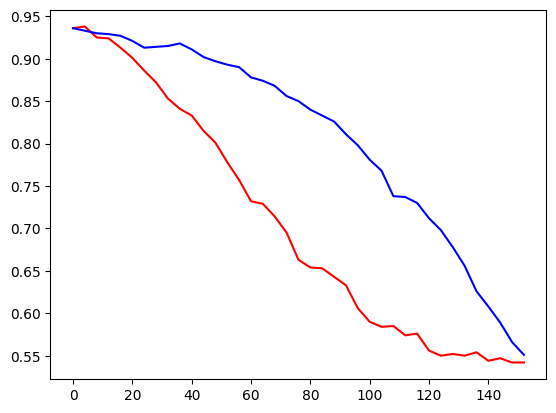

In [37]:
plt.plot(x_axis, y_axis_morf, color="red")
plt.plot(x_axis, y_axis_lerf, color="blue")
plt.show()

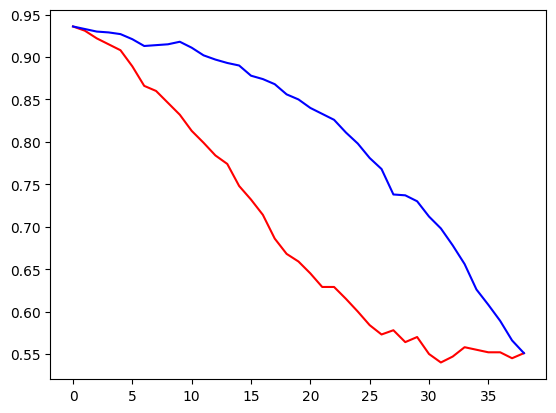

In [39]:
plt.plot(x_axis, y_axis_morf, color="red")
plt.plot(x_axis, y_axis_lerf, color="blue")
plt.show()

In [40]:
from sklearn.metrics import auc
import numpy as np

# ABC
abc = auc(x_axis, y_axis_lerf) - auc(x_axis, y_axis_morf)

# Comprehensiveness
baseline = y_axis_morf[0]
comprehensiveness = auc(x_axis, np.full_like(y_axis_morf, baseline)) - auc(x_axis, y_axis_morf)

# Sufficiency  
sufficiency = auc(x_axis, np.full_like(y_axis_lerf, baseline)) - auc(x_axis, y_axis_lerf)
print(abc / 160, comprehensiveness / 160, sufficiency / 160)

0.10138750000000005 0.21915000000000012 0.11776250000000008


In [38]:
from sklearn.metrics import auc
import numpy as np

# ABC
abc = auc(x_axis, y_axis_lerf) - auc(x_axis, y_axis_morf)

# Comprehensiveness
baseline = y_axis_morf[0]
comprehensiveness = auc(x_axis, np.full_like(y_axis_morf, baseline)) - auc(x_axis, y_axis_morf)

# Sufficiency  
sufficiency = auc(x_axis, np.full_like(y_axis_lerf, baseline)) - auc(x_axis, y_axis_lerf)
print(abc, comprehensiveness, sufficiency)

4.382000000000005 9.092500000000008 4.710500000000003


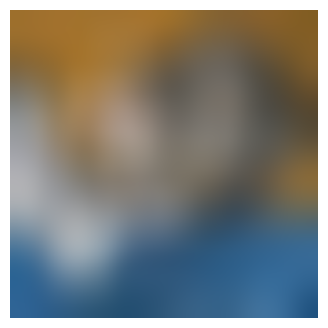

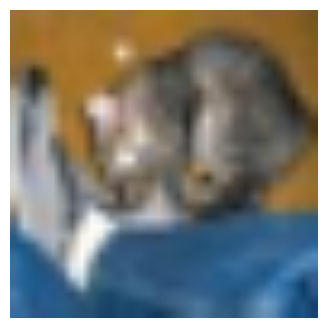

In [34]:

blurred = blur(imgs_list[0])
plot_img(blurred)
plot_img(imgs_list[0])

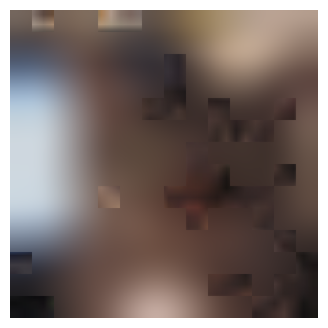

In [27]:
plot_img(morf_imgs_list[120])

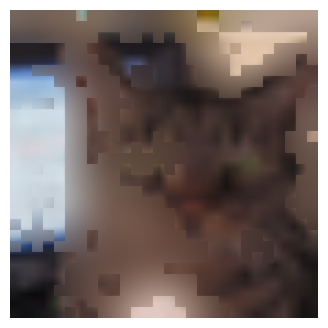

In [55]:
plot_img(morf_imgs_list[120])

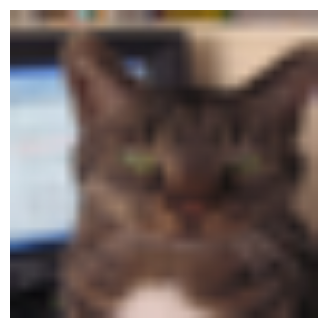

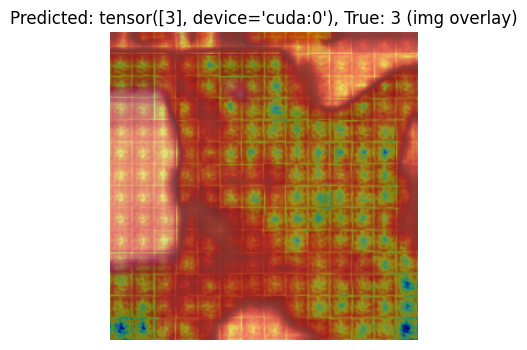

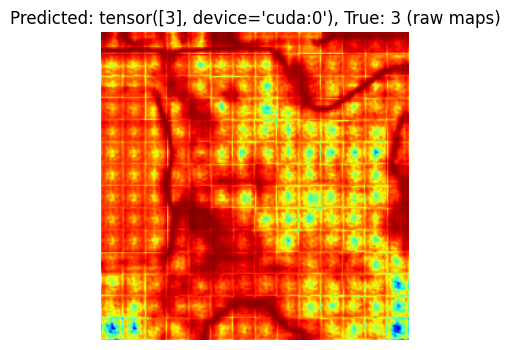

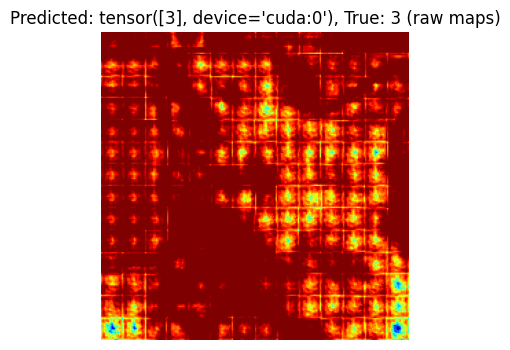

In [22]:
img_ind = 120
img_tensor = imgs_list[img_ind]
true_label = labels_list[img_ind]
pred_idx, hmap = heatmaps[img_ind]
total_heatmap = hmap[0][0] + hmap[0][1] + hmap[0][2]
pos_mask = total_heatmap < 0
clamped_heatmap = total_heatmap.clamp(min=total_heatmap.quantile(0.0), max=total_heatmap.quantile(0.5))
plot_img(img_tensor)
visualize_attributions(img_tensor.squeeze(0).detach(), total_heatmap.cpu(), title=f"Predicted: {pred_idx}, True: {true_label} (img overlay)")
visualize_attributions(img_tensor.squeeze(0).detach(), total_heatmap.cpu(), title=f"Predicted: {pred_idx}, True: {true_label} (raw maps)", show_img=False)
visualize_attributions(img_tensor.squeeze(0).detach(), clamped_heatmap.cpu(), title=f"Predicted: {pred_idx}, True: {true_label} (raw maps)", show_img=False)

In [11]:
promises = list(lrp_engine.promise_bucket.start_nodes_to_promise.keys())
len(promises)

76